# Генерация текста с помощью LSTM-сетей

Сеть способна выучить распределение символов в последовательностях


Датасет формируем проходясь окном по текстовому корпусу, задача сети - предсказывать следующий символ на основании нескольких предыдущих.
Данный подход можно улучшить, используя только отдельные предложения с паддингами.

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

In [2]:
import pandas as pd
from tqdm import tqdm

### 0. Получение данных для обучения

Для обучения используется датасет российских новостей, который был сохранён в файл `text_corpus.parquet` со следующими параметрами:

In [12]:
# data.to_parquet("text_corpus.parquet", engine="pyarrow", compression="gzip", index=False)

In [3]:
data = pd.read_parquet("text_corpus.parquet", engine="pyarrow", )

In [4]:
len(data)

50000

In [5]:
# после обучения токенизатора можно уменьшить тренировочную выборку
# но нужно не забыть обновить переменную corpus
data = data.sample(10000)

### 1. Вспомогательные функции:
+ Визуализация процесса обучения
    + Сможем посмотреть, как меняется качество с течением времени.
+ Коллбек ModelCheckpoint
    + Процесс обучения LSTM сетей достаточно длительный. Будет обидно, если из-за непредвиденного сбоя потеряется прогресс за многие часы обучения.
+ Колбек динамической подстройки размера батча и learning rate
    + Подстраивать LR это уже стандартная практика, а я хочу ещё и размер батча менять: предположу, что большой батч позволит дать некое "обобщённое" представление о распределении токенов, а маленький батч улучшит "грамотность".



In [6]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [7]:
ModelCheckpointCb = ModelCheckpoint(
    filepath="./model2_checkpoints/", 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True,
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch',
    options=None
)

In [8]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


LearningRateSchedulerCb = LearningRateScheduler(
    scheduler, 
    verbose=0
)


In [9]:
# весь текст одной "портянкой", чтобы заранее оценить, какие символы могут нам попадаться
# raw_text = " ".join(data.text)
# chars = sorted(list(set(raw_text)))
# chars

### 3. Предобработка и создание датасета

Для тренировки LSTM модели понадобится немного поработать с форматами

#### 3.1 Токенизация BPE 

BPE токенизация посредством yttm эффективна, но потребуется поработать с файлом

In [9]:
import youtokentome as yttm
import re

In [10]:
total_words = 800
max_sequence_length = 80
n_samples = 800000 # сколько тренировочных последовательностей потом сгенерируем из корпуса

##### 3.2 Создаём токенизатор BPE и обучаем его

In [11]:
corpus = " \n".join(data.text.to_list()).lower()
# Хочу отделить всю пунктуацию от слов пробелом
corpus = " ".join(re.findall(r"[\w']+|[.,!?;\n]", corpus))

In [12]:
train_data_path = "yttm_train_data.txt"
bpe_model_path = "bpe.yttm"

In [20]:
with open(train_data_path, "w") as _file:
    _file.writelines(corpus)

In [21]:
# Training model
# (data, model, vocab_size, coverage, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3)
bpe = yttm.BPE.train(data=train_data_path, vocab_size=total_words, model=bpe_model_path)

In [13]:
# Loading model
bpe = yttm.BPE(model=bpe_model_path)

In [14]:
print(' '.join(bpe.vocab())[:300])

<PAD> <UNK> <BOS> <EOS> ▁ о е и а н т с р в л к п д м у я ы г з б , ь ч й . х ж ' ц ю ш ф щ э ъ ? ё ! ; _ ▁п ▁с ▁в ▁, ст ни ра ро но ре на ▁о ко то ▁. ▁и ▁по го не де те ли ва ▁м за ны ▁на ль ка ри та ле ла ▁д во ве ▁б ти ци ▁со ви ▁ч ки ло ▁у ▁за ▁' да ть ен ми ▁а ▁не ▁ко сс ▁пре ет ру ся ди ▁про н


In [102]:
# encode(self, 
#     sentences, 
#     output_type=yttm.OutputType.ID, 
#     bos=False, 
#     eos=False, 
#     reverse=False, 
#     dropout_prob=0)

In [15]:
encoded_corpus = np.array(bpe.encode(corpus))

# sequences = sequence[:-(len(sequence)%max_sequence_length)].reshape((len(sequence)//max_sequence_length, max_sequence_length))

In [16]:
dataset = []
# берём не больше семплов чем n_samples, 
# или не больше чем максимально возможное количество, если вдруг оно меньше n_samples
for i in tqdm(range(min(len(encoded_corpus)-max_sequence_length, n_samples))):
        # сами добавляем BOS и EOS токены 
#         dataset.append([2] + encoded_corpus[i: i+max_sequence_length - 2] + [3])
    dataset.append(encoded_corpus[i: i+max_sequence_length - 2])
        

100%|██████████| 800000/800000 [00:00<00:00, 2482069.84it/s]


In [17]:
# на всякий случай убедимся, что все последовательности точно одной длины
# за одно это сконвертирует в np.array
dataset = pad_sequences(dataset, 
                        maxlen=max_sequence_length, 
                        padding='pre', 
                        value=0).astype(np.float32)

In [18]:
bpe.decode([list(dataset[5,:])])

["<PAD><PAD>нением артиллерии и стрелкового оружия идет в районе населенного пункта бирюково луганская область , сообщили в среду агентству 'интерфакс' очевидцы . 'в эти часы идет боестолкновение примерно в дву"]

------------------
Собираем данные в нужные структуры

In [19]:
X, y = dataset[:,:-1], to_categorical(dataset[:,-1], num_classes=total_words)

In [20]:
X = X.reshape((*X.shape, 1))

In [21]:
X.shape


(800000, 79, 1)

In [22]:
y.shape

(800000, 800)

## 4. Модель

В качестве модели будет применяться LSTM сеть с двумя слоями LSTM

TODO
+ Gradient clipping
+ More layers?

In [93]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

In [50]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 99, 256)           264192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65)                16705     
Total params: 806,209
Trainable params: 806,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X, y, 
    epochs=1, 
    verbose=1,
    callbacks=[ModelCheckpointCb],
    batch_size=500, 
    validation_split=0.3, 
#     validation_data=(X_test, y_test), 
    shuffle=False, 
#     class_weight=None,
#     sample_weight=None, 
#     initial_epoch=0, 
#     steps_per_epoch=None,
#     validation_steps=None, 
#     validation_batch_size=None, 
#     validation_freq=1,
#     max_queue_size=10, 
#     workers=1, 
#     use_multiprocessing=False
)

In [23]:
model2 = Sequential()
model2.add(LSTM(18))
model2.add(Dropout(0.2))
model2.add(Dense(y.shape[1], activation='softmax'))

In [24]:
model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [25]:
history = model2.fit(X, y, 
    epochs=100, 
    verbose=1,
    callbacks=[ModelCheckpointCb, LearningRateSchedulerCb],
    batch_size=16, 
    validation_split=0.3, 
#     validation_data=(X_test, y_test), 
    shuffle=True, 
#     class_weight=None,
#     sample_weight=None, 
#     initial_epoch=0, 
#     steps_per_epoch=None,
#     validation_steps=None, 
#     validation_batch_size=None, 
#     validation_freq=1,
#     max_queue_size=10, 
#     workers=1, 
#     use_multiprocessing=False
)

Epoch 1/100
35000/35000 [==============================] - 376s 11ms/step - loss: 5.9751 - accuracy: 0.0300 - val_loss: 5.8523 - val_accuracy: 0.0333
Epoch 2/100
35000/35000 [==============================] - 369s 11ms/step - loss: 5.8679 - accuracy: 0.0332 - val_loss: 5.8133 - val_accuracy: 0.0371
Epoch 3/100
35000/35000 [==============================] - 371s 11ms/step - loss: 5.8369 - accuracy: 0.0346 - val_loss: 5.7910 - val_accuracy: 0.0387
Epoch 4/100
35000/35000 [==============================] - 370s 11ms/step - loss: 5.8180 - accuracy: 0.0352 - val_loss: 5.7845 - val_accuracy: 0.0387
Epoch 5/100
35000/35000 [==============================] - 371s 11ms/step - loss: 5.8121 - accuracy: 0.0350 - val_loss: 5.7744 - val_accuracy: 0.0386
Epoch 6/100
35000/35000 [==============================] - 372s 11ms/step - loss: 5.8095 - accuracy: 0.0358 - val_loss: 5.7883 - val_accuracy: 0.0391
Epoch 7/100
35000/35000 [==============================] - 373s 11ms/step - loss: 5.8112 - accuracy:

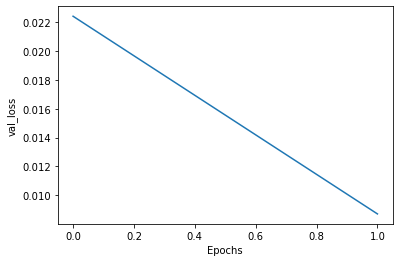

In [114]:
plot_graphs(history, 'val_loss')

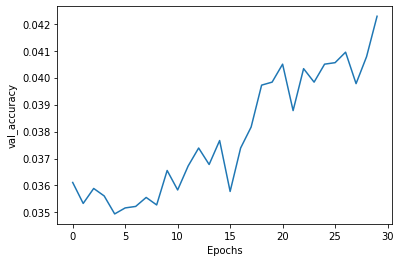

In [105]:
plot_graphs(history, 'val_accuracy')

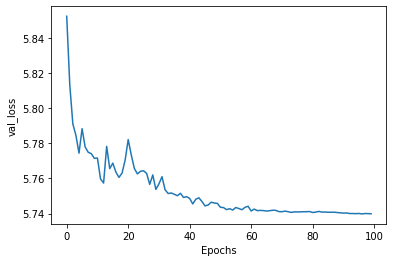

In [26]:
plot_graphs(history, 'val_loss')

In [27]:
model2.save('lstm1layer_model')

INFO:tensorflow:Assets written to: lstm1layer_model/assets


INFO:tensorflow:Assets written to: lstm1layer_model/assets


## 5. Инференс полученной модели

In [102]:
# Для обычного токенайзера
composition = "приветствие затянулось на несколько "
next_words = 200
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([composition])[0]
    token_list = pad_sequences([token_list], maxlen=window_length-1, padding='pre')
    token_list = token_list.reshape((1,window_length-1,1))
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_character = tokenizer.sequences_to_texts([predicted])[0]
    composition += output_character
print(composition)

приветствие затянулось на несколько вродители,
им зае призиденторта согорами в сосесуми рроведе с сосрийской ке просева об пнобо с общела он вобороднтое влодедать в инсотия чесьдае в сосрий сазорунотти в соссий сакали проведа пода саков


In [120]:
output_character

['<PAD>']

In [72]:
bpe.decode([list(X[522].reshape((max_sequence_length-1)))])

["не планирует передислоцировать наблюдательные пункты в идлибской зоне деэскалации , при этом турция продолжит отправлять военных и бронетехнику в этот район 'в целях защиты мирного населения' . ка"]

In [28]:
# Для bpe
composition = "не планирует передислоцировать наблюдательные пункты в идлибской зоне деэскалации , при этом турция продолжит отправлять военных и бронетехнику в этот район 'в целях защиты мирного населения' . ка"
next_words = 200
  
for _ in range(next_words):
    token_list = bpe.encode(composition)
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre', truncating="pre")
    token_list = token_list.reshape((1,max_sequence_length-1,1))
    predicted = np.argmax(model2.predict(token_list), axis=-1)
    output_character = bpe.decode([predicted])[0]
    composition += output_character
print(composition)

не планирует передислоцировать наблюдательные пункты в идлибской зоне деэскалации , при этом турция продолжит отправлять военных и бронетехнику в этот район 'в целях защиты мирного населения' . ка,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [57]:
bpe.encode(["приветствие затянулось на несколько "])

[[126, 341, 322, 6, 90, 10, 20, 156, 603, 71, 97, 109, 448]]

In [44]:
import random

In [45]:
def return_ordered_indices(ar):
    d = {i:v for i,v in enumerate(ar)}
    return sorted(d, key=d.get, reverse=True)

In [46]:
# ensures always sums to 1
def normalize_softmax(ar):
    s = sum(ar)
    if (s!=1):
        ar[0] += 1-s
    return ar
        

In [47]:
composition = "как было сказано "
next_words = 200
T = 2 # токены из top-T будут случайно выбираться
temperature = 1 # параметр сглаживания распределения выбранных токенов
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([composition])[0]
    token_list = pad_sequences([token_list], maxlen=window_length-1, padding='pre')
    token_list = token_list.reshape((1,window_length-1,1))
    
    output = model2.predict(token_list)
    topmost_indicies = return_ordered_indices(output[0, :])[:T]
    probs = tf.nn.softmax(output[0, topmost_indicies] /  temperature).numpy()
    probs = normalize_softmax(probs)
    predicted = np.random.choice(topmost_indicies, p=probs)
#     predicted = topmost_indicies[0]
    output_character = tokenizer.sequences_to_texts([[predicted]])[0]
    composition += output_character
print(composition)

как было сказано осенее с онкет пантоти и ресетиеее ес о осессон в паттеле онти портовония сакомо презедлитеви презисселе нерари соргорам сосриий,
подономо по накраветения подоваи полодать по накогния сообщал возении,
